## Screening

In this notebook we show how we generate a library of photoswitches and used that to screen for the most promising molecules, while also attempting to verify our predictions 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

from src.utils import load_features_and_labels
from src.gaussian_process import train_gp_model
from src.library import generate_smiles

from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import Calculator, descriptors, error

D:\Anaconda3\envs\molbert\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
D:\Anaconda3\envs\molbert\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=Tru

### First we generate our library of photoswitches, see the docs of generate_smiles to understand better how this works

In [3]:
parent_mols = [
  '[U](C1=CC=C(C=C1)N=NC2=CC=C([U])C=C2)', # azobenzene
  'C2(=CC=C([U])[N]2)N=NC3=CC=C([U])[N]3', # bisazopyrrole
  'C2(=CC=C([U])[S]2)N=NC3=CC=C([U])[S]3', # bisazothiophene
  'C2(=CC=C([U])[O]2)N=NC3=CC=C([U])[O]3', # bisazofuran
]

linkers = [
  '([H])',                                # H-terminus
  '(c2ccc([Y])cc2)',                      # benzene
  '(c2ncc([Y])cc2)',                      # pyridine
  '(c2ncc([Y])cn2)',                      # pyrimidine
  '(c2nnc([Y])nn2)',                      # tetrazine
  'C2=CC=C([Y])C2',                       # cyclopentadiene
  '(c2ccc([Y])N2)',                       # pyrrole (2,5) 
  '(c2cc([Y])cN2)',                       # pyrrole (2,4) 
  '(c2ccc([Y])N(C)2)',                    # pyrrole(N-methyl) 
  '(c2ccc([Y])N(C=O)2)',                  # pyrrole(N-COH)
  '(c1cnc([Y])N1)',                       # imidazole
  'c2ccc([Y])O2',                         # furan
  'c2ccc([Y])S2',                         # thiophene
  '(c2ccc([Y])S(=O)(=O)2)',               # thiophene(dioxide)
  '(c2sc([Y])cn2)',                       # thiazole (2,5)
  '(c2scc([Y])n2)',                       # thiazole (2,4)
  '(c1ncc([Y])o1)',                       # oxazole (2,5)
  '(c1nc([Y])co1)',                       # oxazole (2,4)
  '(C#C[Y])',                             # acetylene
  '/C=C/[Y]',                             # ethylene(trans)
  '(C=N[Y])'                              # imine
] 

terminals = [
  '([H])',                                # hydrogen
  '([OH])',                               # hydroxy 
  '[C](F)(F)F',                           # trifluoromethyl 
  '[O][C](F)(F)F',                        # trifluoromethoxy 
  '[C]',                                  # methyl
  '[O][C]',                               # methoxy 
  '[N+]([O-])=O',                         # nitro 
  '([SH])',                               # thiol 
  '[F]',                                  # fluoro 
  '[Cl]',                                 # chloro 
  'C#N'                                   # cyano 
]

generate_smiles('./raw_data/library_01.txt', parent_mols, linkers, terminals)

221
221
221
221


### And we train our Gaussian Process Regression model once more

In [4]:
X, y = load_features_and_labels('./processed_data/initial_dataset/mordred_descriptors.csv' ,'./raw_data/photoswitches.csv' ,'e_iso_pi')
model, x_scaler, y_scaler = train_gp_model(X, y)


Beginning training loop...

mean R^2: 0.9045 +- 0.0080
mean RMSE: 20.1811 +- 0.8257
mean MAE: 12.8562 +- 0.4907



### And now we load in our library and generate all the descriptors for the molecules in it

In [14]:
smiles_list = []
with open('./raw_data/library_01.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    smiles_list.append(line.rstrip())

rdkit_mols = [MolFromSmiles(smiles) for smiles in smiles_list]

calc = Calculator(descriptors)

mordred_descriptors = calc.pandas(rdkit_mols)

error_columns = []
for i, e in enumerate(mordred_descriptors.dtypes):
    if e=="object":
        error_columns += [i]
        
mordred_descriptors = mordred_descriptors.drop(mordred_descriptors.columns[error_columns], axis=1)
mordred_descriptors = mordred_descriptors.dropna(axis=1)
mordred_descriptors.insert(0, "SMILES", smiles_list)
mordred_descriptors.to_csv('./processed_data/library_01/lib_mordred.csv')

100%|██████████| 872/872 [01:49<00:00,  7.94it/s]


In [15]:
df1 = pd.read_csv('./processed_data/initial_dataset/mordred_descriptors.csv')
original_columns = df1.columns[2:]

df2 = pd.read_csv('./processed_data/library_01/lib_mordred.csv')
remove_columns = []
for column in df2.columns[2:]:
  if column not in original_columns:
    print(column)
    remove_columns.append(column)
    
df2 = df2.drop(labels=remove_columns, axis=1)

df2.to_csv('./processed_data/library_01/lib_mordred.csv')

MAXaaCH
MINaaCH
MDEC-22
MDEC-23
Vabc


In [4]:
mordred_descriptors = pd.read_csv('./processed_data/library_01/lib_mordred.csv')

### With all the molecules and the descriptors loaded up, we now througput them to the model and collect the mean and variance of each molecules predicted transition wavelength

In [7]:
means = []
vars = []
scaled_vars = []

for idx, row in mordred_descriptors.iterrows():
  features = row.to_numpy()[3:].reshape(1, -1)
  features = x_scaler.transform(features)
  mean, var = model.predict_f(features)
  means.append(y_scaler.inverse_transform(mean)[0][0])
  vars.append(var[0][0].numpy())
  scaled_vars.append(y_scaler.inverse_transform(var)[0][0])
  
mordred_descriptors.insert(loc=0, column='mean', value=means)
mordred_descriptors.insert(loc=0, column='var', value=vars)

AttributeError: 'float' object has no attribute 'dtype'

### which allows us to screen for a particular wavelength, for example 450 nm

In [58]:
# mordred_descriptors = mordred_descriptors.drop(columns=['desired_wavelength_dist'])
desired_wavelength = 450
mordred_descriptors.insert(loc=0, column='desired_wavelength_dist', value=(mordred_descriptors['mean']-desired_wavelength).abs())

In [59]:
top_molecules = mordred_descriptors.sort_values(['desired_wavelength_dist', 'var'], ascending=[True, True]).head(10)
top_molecules

desired_wavelength_dist       var        mean  Unnamed: 0  Unnamed: 0.1  \
243                 0.134439  0.304277  450.134439         243           243   
469                 0.375237  0.332185  449.624763         469           469   
605                 0.386888  0.365937  449.613112         605           605   
443                 0.389148  0.344787  449.610852         443           443   
506                 0.447570  0.295745  450.447570         506           506   
72                  0.499664  0.285938  449.500336          72            72   
291                 0.527157  0.356512  449.472843         291           291   
505                 0.653759  0.358020  449.346241         505           505   
90                  0.666972  0.289218  449.333028          90            90   
4                   0.691855  0.262491  450.691855           4             4   

                                                SMILES        ABC      ABCGG  \
243  COc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(OC)n4C)[nH]3)[n...  21.896449  18.238429   
469    COc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(OC)cn4)s3)s2)nc1  21.839430  16.112720   
605  N#Cc1nnc(-c2ccc(N=Nc3ccc(-c4nnc(C#N)nn4)s3)s2)nn1  21.839430  16.112720   
443      Oc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(O)cn4)s3)s2)nc1  20.643996  15.435095   
506  O=[N+]([O-])c1ccc(-c2ccc(N=Nc3ccc(-c4ccc([N+](...  22.196109  17.821670   
72       Fc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(F)s4)cc3)cc2)s1  20.643996  15.109884   
291  N#Cc1ncc(-c2ccc(N=Nc3ccc(-c4cnc(C#N)[nH]4)[nH]...  20.425216  16.550548   
505      Cn1c(S)ccc1-c1ccc(N=Nc2ccc(-c3ccc(S)n3C)s2)s1  20.701015  17.365380   
90   N#Cc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(C#N)o4)cc3)cc2)o1  21.839430  15.829305   
4      Cn1c(O)ccc1-c1ccc(N=Nc2ccc(-c3ccc(O)n3C)cc2)cc1  22.115229  16.650607   

     nAcid  nBase  ...      SRW10     TSRW10          MW        AMW  WPath  \
243      0      0  ...  10.185013  81.188746  378.180424   7.563608   2414   
469      0      0  ...  10.076726  78.668861  410.061966   9.763380   2540   
605      0      0  ...  10.076726  78.668861  404.012330  12.625385   2540   
443      0      0  ...  10.021226  76.388269  382.030666  10.611963   2023   
506      0      0  ...  10.097532  80.851181  415.988526  11.555237   2496   
72       0      0  ...  10.022115  76.363858  384.031495  10.667542   2075   
291      0      0  ...   9.979476  78.358059  342.108990   9.503028   2025   
505      0      0  ...  10.128190  78.901563  416.025781   9.905376   1943   
90       0      0  ...  10.076726  78.668861  366.086524   9.633856   2592   
4        0      0  ...  10.212552  79.345237  372.158626   7.753305   2502   

     WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
243    41    150.0    180.0  8.611111  6.250000  
469    39    146.0    170.0  7.388889  6.305556  
605    39    146.0    170.0  7.388889  6.305556  
443    35    138.0    160.0  6.888889  5.638889  
506    37    150.0    176.0  8.611111  6.027778  
72     35    138.0    160.0  6.888889  5.638889  
291    33    138.0    162.0  6.888889  5.805556  
505    37    142.0    170.0  8.111111  5.583333  
90     39    146.0    170.0  7.388889  6.305556  
4      43    150.0    178.0  8.611111  6.083333  

[10 rows x 1433 columns]

In [60]:
for smiles in top_molecules['SMILES']:
  print(smiles)

COc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(OC)n4C)[nH]3)[nH]2)n1C
COc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(OC)cn4)s3)s2)nc1
N#Cc1nnc(-c2ccc(N=Nc3ccc(-c4nnc(C#N)nn4)s3)s2)nn1
Oc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(O)cn4)s3)s2)nc1
O=[N+]([O-])c1ccc(-c2ccc(N=Nc3ccc(-c4ccc([N+](=O)[O-])o4)s3)s2)o1
Fc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(F)s4)cc3)cc2)s1
N#Cc1ncc(-c2ccc(N=Nc3ccc(-c4cnc(C#N)[nH]4)[nH]3)[nH]2)[nH]1
Cn1c(S)ccc1-c1ccc(N=Nc2ccc(-c3ccc(S)n3C)s2)s1
N#Cc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(C#N)o4)cc3)cc2)o1
Cn1c(O)ccc1-c1ccc(N=Nc2ccc(-c3ccc(O)n3C)cc2)cc1


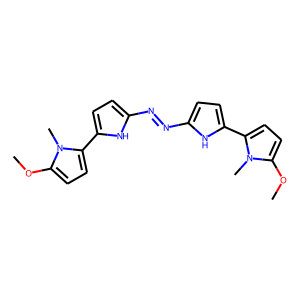

predicted wavelength:  450.13443865501324  , variance:  0.30427713729126893




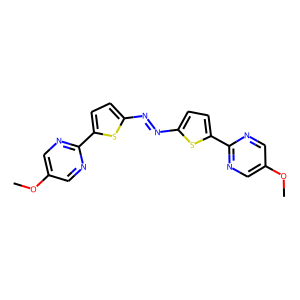

predicted wavelength:  449.6247630189172  , variance:  0.3321853024784701




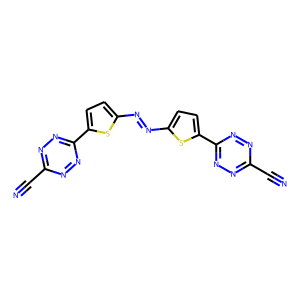

predicted wavelength:  449.61311158041156  , variance:  0.3659371905316849




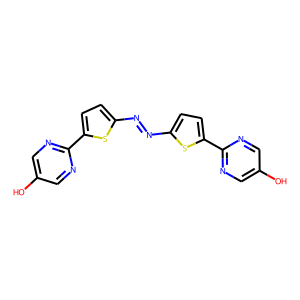

predicted wavelength:  449.6108524594586  , variance:  0.3447866028374412




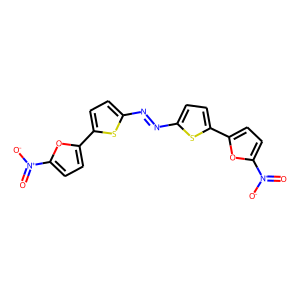

predicted wavelength:  450.4475700794066  , variance:  0.29574512714953116




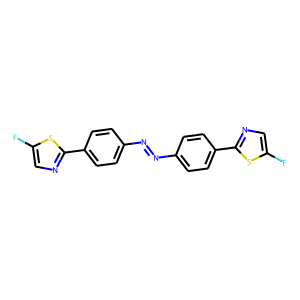

predicted wavelength:  449.5003356356907  , variance:  0.2859379040035258




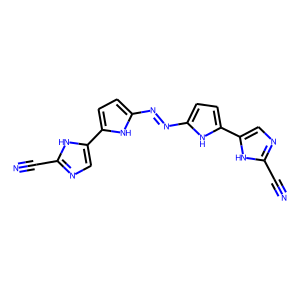

predicted wavelength:  449.47284259043084  , variance:  0.3565116897224747




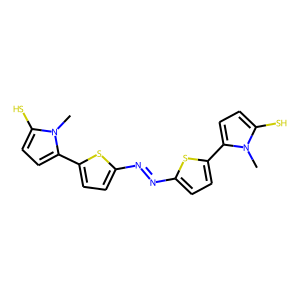

predicted wavelength:  449.3462411800078  , variance:  0.3580197304013704




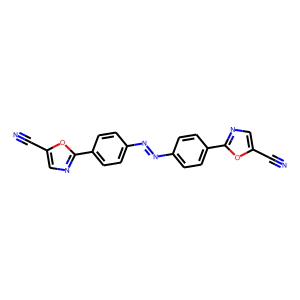

predicted wavelength:  449.3330275110255  , variance:  0.28921775554538576




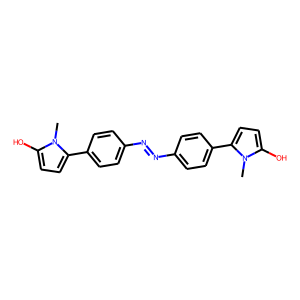

predicted wavelength:  450.6918545128566  , variance:  0.262491490194134




In [40]:
top_smiles = top_molecules['SMILES']
means = top_molecules['mean']
vars = top_molecules['var']

for (smiles, mean, var) in zip(top_smiles, means, vars):
  image = Draw.MolToImage(Chem.MolFromSmiles(smiles))
  display(image)
  print('predicted wavelength: ', mean, ' , variance: ', var)
  print('\n')

### Let's also try out 650 nm

In [52]:
mordred_descriptors = mordred_descriptors.drop(columns=['desired_wavelength_dist'])

desired_wavelength = 650
mordred_descriptors.insert(loc=0, column='desired_wavelength_dist', value=(mordred_descriptors['mean']-desired_wavelength).abs())

In [53]:
top_molecules = mordred_descriptors.sort_values(['desired_wavelength_dist', 'var'], ascending=[True, True]).head(10)
top_molecules

desired_wavelength_dist       var        mean  Unnamed: 0  Unnamed: 0.1  \
444               144.612390  0.296652  505.387610         444           444   
570               155.643134  0.305664  494.356866         570           570   
512               157.836804  0.322307  492.163196         512           512   
609               158.350819  0.309561  491.649181         609           609   
556               159.413288  0.241548  490.586712         556           556   
602               162.392267  0.315179  487.607733         602           602   
520               163.174831  0.279146  486.825169         520           520   
205               165.302619  0.259882  484.697381         205           205   
538               165.623895  0.264564  484.376105         538           538   
124               166.328876  0.258582  483.671124         124           124   

                                                SMILES        ABC      ABCGG  \
444  Cn1c(C#N)ccc1-c1ccc(N=Nc2ccc(-c3ccc(C#N)n3C)s2)s1  21.896449  18.238429   
570  N#Cc1c[nH]c(-c2ccc(N=Nc3ccc(-c4cc(C#N)c[nH]4)s...  20.425216  16.550548   
512  N#Cc1ncc(-c2ccc(N=Nc3ccc(-c4cnc(C#N)[nH]4)s3)s...  20.425216  16.550548   
609  N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)[nH]4)s3)s...  20.425216  16.550548   
556  N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)cc4)s3)s2)cc1  21.839430  16.112720   
602    N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)s4)s3)s2)s1  20.425216  16.550548   
520  N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)n4C=O)s3)s...  23.091883  19.427486   
205  N#Cc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(C#N)s4)cc3)cc2)s1  21.839430  15.829305   
538  N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)cn4)s3)s2)nc1  21.839430  16.112720   
124  N#Cc1csc(-c2ccc(N=Nc3ccc(-c4nc(C#N)cs4)cc3)cc2)n1  21.839430  15.829305   

     nAcid  nBase  ...      SRW10     TSRW10          MW        AMW  WPath  \
444      0      0  ...  10.185013  81.188746  402.072136   9.573146   2414   
570      0      0  ...   9.979476  78.358059  374.040836  10.390023   2025   
512      0      0  ...   9.979476  78.358059  376.031334  11.059745   2025   
609      0      0  ...   9.979476  78.358059  374.040836  10.390023   2025   
556      0      0  ...  10.076726  78.668861  396.050338   9.901258   2540   
602      0      0  ...   9.979476  78.358059  407.963180  11.998917   2025   
520      0      0  ...  10.247325  83.472674  430.030666  10.750767   2887   
205      0      0  ...  10.076726  78.668861  398.040836  10.474759   2592   
538      0      0  ...  10.076726  78.668861  398.040836  10.474759   2540   
124      0      0  ...  10.076726  78.668861  398.040836  10.474759   2592   

     WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
444    41    150.0    180.0  8.611111  6.250000  
570    33    138.0    162.0  6.888889  5.805556  
512    33    138.0    162.0  6.888889  5.805556  
609    33    138.0    162.0  6.888889  5.805556  
556    39    146.0    170.0  7.388889  6.305556  
602    33    138.0    162.0  6.888889  5.805556  
520    45    158.0    190.0  9.111111  6.916667  
205    39    146.0    170.0  7.388889  6.305556  
538    39    146.0    170.0  7.388889  6.305556  
124    39    146.0    170.0  7.388889  6.305556  

[10 rows x 1433 columns]

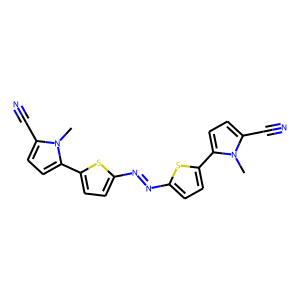

predicted wavelength:  505.38760985854753  , variance:  0.296651590159164




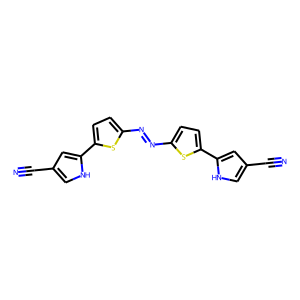

predicted wavelength:  494.3568660661983  , variance:  0.3056642054837285




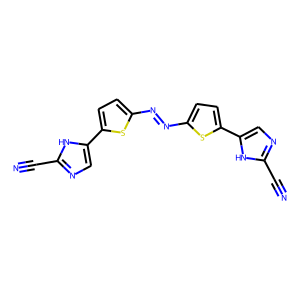

predicted wavelength:  492.1631964897849  , variance:  0.3223074976618907




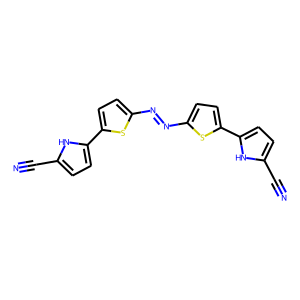

predicted wavelength:  491.6491810574721  , variance:  0.3095612787237261




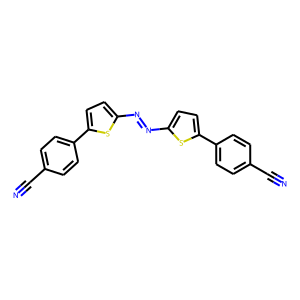

predicted wavelength:  490.58671242307514  , variance:  0.24154809285320755




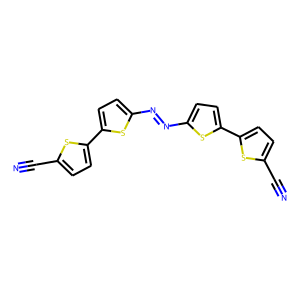

predicted wavelength:  487.6077325725759  , variance:  0.31517880126017644




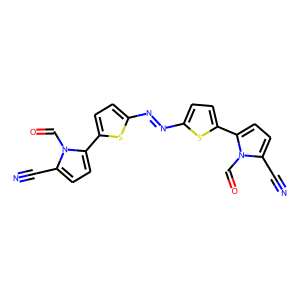

predicted wavelength:  486.8251691907916  , variance:  0.2791463948595237




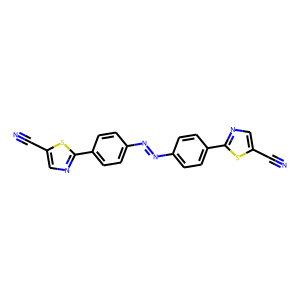

predicted wavelength:  484.6973807399112  , variance:  0.2598820107113635




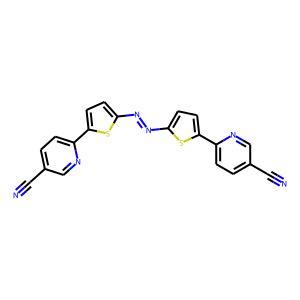

predicted wavelength:  484.3761048869161  , variance:  0.2645637957903465




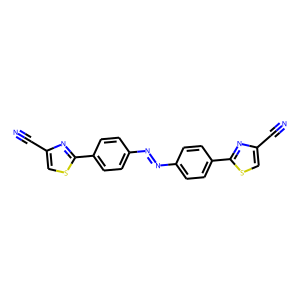

predicted wavelength:  483.6711235173088  , variance:  0.25858176909953784




In [54]:
top_smiles = top_molecules['SMILES']
means = top_molecules['mean']
vars = top_molecules['var']

for (smiles, mean, var) in zip(top_smiles, means, vars):
  image = Draw.MolToImage(Chem.MolFromSmiles(smiles))
  display(image)
  print('predicted wavelength: ', mean, ' , variance: ', var)
  print('\n')

In [56]:
for smiles in top_smiles:
  print(smiles)

Cn1c(C#N)ccc1-c1ccc(N=Nc2ccc(-c3ccc(C#N)n3C)s2)s1
N#Cc1c[nH]c(-c2ccc(N=Nc3ccc(-c4cc(C#N)c[nH]4)s3)s2)c1
N#Cc1ncc(-c2ccc(N=Nc3ccc(-c4cnc(C#N)[nH]4)s3)s2)[nH]1
N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)[nH]4)s3)s2)[nH]1
N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)cc4)s3)s2)cc1
N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)s4)s3)s2)s1
N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)n4C=O)s3)s2)n1C=O
N#Cc1cnc(-c2ccc(N=Nc3ccc(-c4ncc(C#N)s4)cc3)cc2)s1
N#Cc1ccc(-c2ccc(N=Nc3ccc(-c4ccc(C#N)cn4)s3)s2)nc1
N#Cc1csc(-c2ccc(N=Nc3ccc(-c4nc(C#N)cs4)cc3)cc2)n1


### Conclusion
The screening seems to be going well for the 450 nm wavelength, but we don't have sufficient molecules in our library to screen for 650 nm wavelengths, so maybe we could use our VAE to optimize a molecule towards a higher adsorption wavelength

## Running DFT calculations to check these values
Although we didn't have time to run these calculations, we stil produced the code in order to check our predictions with TD-DFT calculations in Orca

In [ ]:
from src.dft import run_orca_calculation, extract_wavelength_from_calculation

for smiles in top_smiles:
  run_orca_calculation('./orca_dir/', smiles)
  
computed_wavelengths = []
for smiles in top_smiles:
  computed_wavelengths.append(extract_wavelength_from_calculation('./orca_dir/', smiles, 'pi-pi*'))